<a href="https://colab.research.google.com/github/machiobrian/Energy/blob/master/HouseHold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# load the kaggle.json file into the space

# instantiate kaggle
! pip install kaggle

#  crate a dir to load the .json file
! mkdir ~/.kaggle

# copy the .json file into kaggle
! cp kaggle.json ~/.kaggle/

# allow RW priiledges
! chmod 600 ~/.kaggle/kaggle.json


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# download the kaggle dataset
! kaggle datasets download -d ecoco2/household-appliances-power-consumption

 99% 248M/251M [00:02<00:00, 148MB/s]
100% 251M/251M [00:02<00:00, 110MB/s]


In [3]:
# its in zip mode thereofore, extract
! unzip household-appliances-power-consumption.zip

Archive:  household-appliances-power-consumption.zip
  inflating: 0_smart_plugs_devices.csv  
  inflating: 3D_printer_29.csv       
  inflating: air_conditioner_222.csv  
  inflating: air_purifier_293.csv    
  inflating: boiler_217.csv          
  inflating: boiler_226.csv          
  inflating: boiler_233.csv          
  inflating: coffee_37.csv           
  inflating: coffee_54.csv           
  inflating: coffee_97.csv           
  inflating: computer_44.csv         
  inflating: dehumidifier_310.csv    
  inflating: dehumidifier_322.csv    
  inflating: dishwasher_53.csv       
  inflating: dryer_219.csv           
  inflating: fan_215.csv             
  inflating: freezer_249.csv         
  inflating: fridge_207.csv          
  inflating: fridge_284.csv          
  inflating: fridge_317.csv          
  inflating: fridge_98.csv           
  inflating: internet_router_131.csv  
  inflating: internet_router_295.csv  
  inflating: laptop_289.csv          
  inflating: laptop_64.csv   

In [4]:
# install all the neccessary libs
%%capture
! pip install pandas as pd

In [5]:
import pandas as pd
# load TV data
df = pd.read_csv('/content/tv_290.csv', parse_dates=["timestamp"])
df.head(5)

,timestamp,power
0,2021-02-11 18:38:39+00:00,1.0
1,2021-02-11 18:38:40+00:00,1.0
2,2021-02-11 18:38:41+00:00,1.0
3,2021-02-11 18:38:42+00:00,1.0
4,2021-02-11 18:38:43+00:00,1.0


In [6]:
df.size
df.columns

Index(['timestamp', 'power'], dtype='object')

In [7]:
# check if dates are parsed
startTimestamp = df['timestamp'].iloc[0]
endTimeStamp = df['timestamp'].iloc[-1]
print(endTimeStamp - startTimestamp)

29 days 23:59:59


In [8]:
# resample to 30 minutes block
mseries = df.resample('30 Min', on='timestamp').power.sum().to_frame(name='power')
mseries.head()

,power
timestamp,
2021-02-11 18:30:00+00:00,1281.0
2021-02-11 19:00:00+00:00,1800.0
2021-02-11 19:30:00+00:00,1800.0
2021-02-11 20:00:00+00:00,1800.0
2021-02-11 20:30:00+00:00,1800.0


In [9]:
type(mseries)

pandas.core.frame.DataFrame

In [10]:
mseries.size

1441

In [11]:
mseries.keys()

Index(['power'], dtype='object')

## Plotting the Data

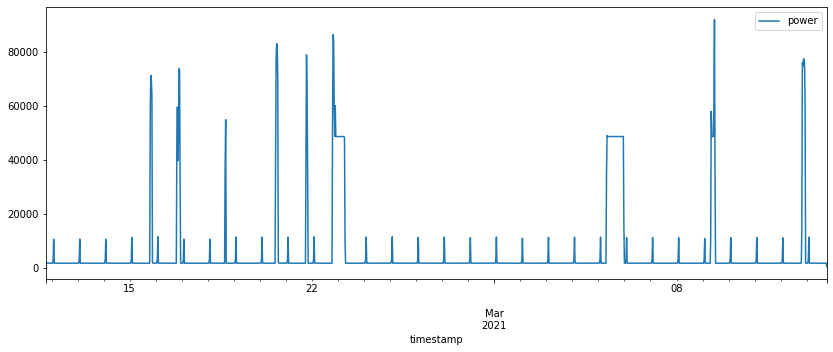

In [14]:
# %matplotlib inline
mseries.plot(figsize=(14,5))

* Time series decomposition

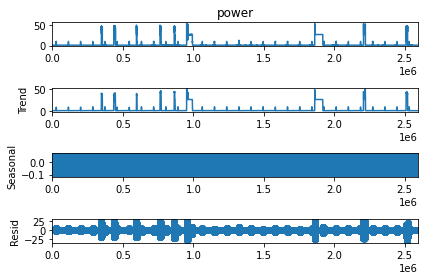

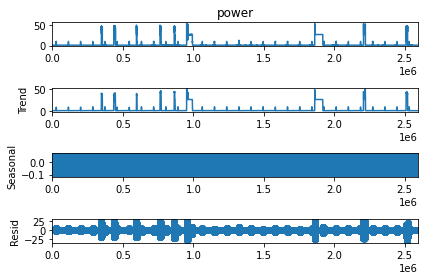

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['power'], period=24*30)
results.plot()

* Train Test Split Dataset

In [19]:
train = mseries.iloc[:1105]
test = mseries.iloc[1105:]

In [20]:
len(train)

1105

In [21]:
len(test)

336

* Normalizing the Data

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [24]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaler_test = scaler.transform(test)

In [25]:
scaled_train[1105:]

array([], shape=(0, 1), dtype=float64)

* Time series Generator

In [26]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [27]:
n_input = 48
gen = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
n_features = 1

* Build the Model

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [29]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit(gen, epochs=15, batch_size=64, verbose=1)

Epoch 1/15
1057/1057 [==============================] - 23s 20ms/step - loss: 0.0147
Epoch 2/15
1057/1057 [==============================] - 22s 20ms/step - loss: 0.0097
Epoch 3/15
1057/1057 [==============================] - 23s 22ms/step - loss: 0.0074
Epoch 4/15
1057/1057 [==============================] - 22s 20ms/step - loss: 0.0063
Epoch 5/15
1057/1057 [==============================] - 22s 21ms/step - loss: 0.0056
Epoch 6/15
1057/1057 [==============================] - 21s 20ms/step - loss: 0.0048
Epoch 7/15
1057/1057 [==============================] - 22s 21ms/step - loss: 0.0046
Epoch 8/15
1057/1057 [==============================] - 21s 20ms/step - loss: 0.0047
Epoch 9/15
1057/1057 [==============================] - 22s 21ms/step - loss: 0.0045
Epoch 10/15
1057/1057 [==============================] - 22s 20ms/step - loss: 0.0046
Epoch 11/15
1057/1057 [==============================] - 21s 20ms/step - loss: 0.0047
Epoch 12/15
1057/1057 [==============================] - 21s 20

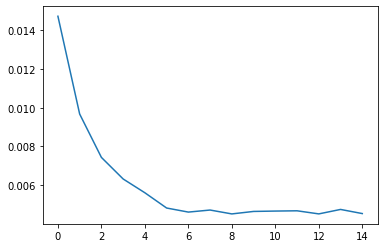

In [33]:
# loss per epoch
loss_per_epoch = model.history.history['loss']

from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [35]:
last_train_batch = scaled_train[-48:
                                ]